<a href="https://colab.research.google.com/github/beatarefada/synthetic-control-jordan/blob/main/Final_SS154_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data/Packages Importing

In [ ]:
# installing key packages
install.packages("gsheet")
install.packages('Synth')
install.packages('dplyr')
library(gsheet)
library(Synth)
library(dplyr)

# Importing data
data <- gsheet2tbl("https://docs.google.com/spreadsheets/d/1Qz5WWtx2iGSX-b_YVL9leFZC7MBABPF68x_0I15ant4/edit#gid=0", sheet='Data')
data <- as.data.frame(data) # convert to data frame
data <- data %>%
    select(-`Refugee population by country or territory of asylum`, -`Refugee population by country or territory of origin`) %>%
    filter(`Year` < 2022, `Country` != "Tunisia")

# Displaying data
head(data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,Country,Country Code,Year,Population,PISA - Mathematics,PISA - Reading,GDP per capita (current USD),Political Stability and Absence of Violence/Terrorism: Percentile Rank,Student:Teacher Ratio
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Argentina,1,2006,39476851,381,374,5890.978,45.89372,11
2,Argentina,1,2009,40684338,388,398,8184.390,36.96682,15
3,Argentina,1,2012,41733271,388,396,13082.664,49.28910,10
4,Argentina,1,2015,43131966,409,425,13789.060,46.19048,NA
5,Argentina,1,2018,44494502,379,402,11795.163,47.16981,10
6,Brazil,2,2006,188820682,370,393,5866.023,35.26570,31


## Missing Data

In [ ]:
# install zoo and tidyr packages
install.packages('zoo')
library(zoo)
install.packages('tidyr')
library(tidyr)

# Identify missing values
missing_indices_math <- which(is.na(data$`PISA - Mathematics`))
missing_indices_read <- which(is.na(data$`PISA - Reading`))
missing_indices_ratio <- which(is.na(data$`Student:Teacher Ratio`))

# Perform linear interpolation
data$PISA_math_filled <- na.approx(data$`PISA - Mathematics`)
data$PISA_read_filled <- na.approx(data$`PISA - Reading`)
data$Student_teach_filled <- na.locf(data$`Student:Teacher Ratio`)

# Fill missing values using linear interpolation for only the identified missing indices
data$PISA_math_filled[missing_indices_math] <- na.approx(data$`PISA - Mathematics`)[missing_indices_math]
data$PISA_read_filled[missing_indices_read] <- na.approx(data$`PISA - Reading`)[missing_indices_read]
data$Student_teach_filled[missing_indices_ratio] <- na.locf(data$`Student:Teacher Ratio`)[missing_indices_ratio]

summary(data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   Country           Country Code         Year        Population       
 Length:70          Min.   : 1.000   Min.   :2006   Min.   :   501863  
 Class :character   1st Qu.: 4.000   1st Qu.:2009   1st Qu.:  3379054  
 Mode  :character   Median : 7.500   Median :2012   Median :  7375166  
                    Mean   : 7.571   Mean   :2012   Mean   : 54094745  
                    3rd Qu.:11.000   3rd Qu.:2015   3rd Qu.: 68821181  
                    Max.   :15.000   Max.   :2018   Max.   :267066843  
                                                                       
 PISA - Mathematics PISA - Reading  GDP per capita (current USD)
 Min.   :318.0      Min.   :242.0   Min.   : 1573               
 1st Qu.:388.0      1st Qu.:402.0   1st Qu.: 5872               
 Median :418.0      Median :420.5   Median : 8954               
 Mean   :433.3      Mean   :430.9   Mean   :18516               
 3rd Qu.:464.0      3rd Qu.:471.0   3rd Qu.:15921               
 Max.   :561.0      Max.   :545.0 

# Summary Statistics

In [ ]:
# Load libraries
library(purrr)
library(knitr)
install.packages("dplyr")
library(dplyr)

# List of variables
vars <- c("PISA_math_filled", "PISA_read_filled", "Population", "GDP per capita (current USD)", "Political Stability and Absence of Violence/Terrorism: Percentile Rank", "Student_teach_filled")
var_names <- c("PISA_math_filled" = "PISA Math",
               "PISA_read_filled" = "PISA Reading",
               "Population" = "Population",
               "GDP per capita (current USD)" = "GDP per capita",
               "Political Stability and Absence of Violence/Terrorism: Percentile Rank" = "Political Stability",
               "Student_teach_filled" = "Student-Teacher Ratio")

# Function to calculate means and medians
calculate_stats <- function(var, var_name) {
    data %>%
        group_by(Year) %>%
        summarize(mean = mean(.data[[var]], na.rm = TRUE), .groups = 'drop') %>%
        mutate(varname_str = var_name)
}

# Calculate means and medians
stats_list <- map2(vars, var_names[vars], calculate_stats)

# Combine the list of data frames into a single data frame
result <- bind_rows(stats_list)

# Print the result
glimpse(result)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Rows: 30
Columns: 3
$ Year        <dbl> 2006, 2009, 2012, 2015, 2018, 2006, 2009, 2012, 2015, 2018…
$ mean        <dbl> 4.235714e+02, 4.294286e+02, 4.354286e+02, 4.385714e+02, 4.…
$ varname_str <chr> "PISA Math", "PISA Math", "PISA Math", "PISA Math", "PISA …


# Synthetic Control Analysis - Mathematics

## Data Prep

In [ ]:
dataprep.math <- dataprep(foo=data,
                         predictors = c("Population", "GDP per capita (current USD)", "Political Stability and Absence of Violence/Terrorism: Percentile Rank", "Student_teach_filled"),
                         predictors.op = "mean",
                         time.predictors.prior=c(2006, 2009),
                         special.predictors = list(
                             list("PISA - Mathematics", 2006, 'mean'),
                             list("PISA - Reading", 2006, 'mean')),
                        dependent = "PISA_math_filled",
                        unit.variable = "Country Code",
                        unit.names.variable = "Country",
                        time.variable = "Year",
                        treatment.identifier = 7,
                        controls.identifier = c(1:6, 8:13, 15),
                        time.optimize.ssr=c(2006, 2009, 2012, 2015, 2018),
                        time.plot=c(2006, 2009, 2012, 2015, 2018)
)

## Synthetic Control Analysis


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 40.09566 

solution.v:
 5.7e-09 0.001367571 0.04390159 7.61542e-05 0.8256574 0.1289973 

solution.w:
 7.725e-05 0.5194862 0.0001719629 0.0003160775 1.73816e-05 0.3032231 4.32048e-05 0.0001592083 0.0001399809 0.0001405562 0.0001432889 0.175947 0.0001347983 



,w.weights,unit.names,unit.numbers
,<dbl>,<chr>,<dbl>
1,0.000,Argentina,1
2,0.519,Brazil,2
3,0.000,Bulgaria,3
4,0.000,Croatia,4
5,0.000,Hong Kong-China,5
6,0.303,Indonesia,6
8,0.000,Macao-China,8
9,0.000,Montenegro,9
10,0.000,Qatar,10


,Treated,Synthetic,Sample Mean
Population,6428020.500,1.830784e+08,55648816.846
GDP per capita (current USD),3048.592,5.007335e+03,14728.870
Political Stability and Absence of Violence/Terrorism: Percentile Rank,27.949,2.950000e+01,53.004
Student_teach_filled,17.500,2.536800e+01,17.038
special.PISA - Mathematics.2006,384.000,3.847120e+02,426.615


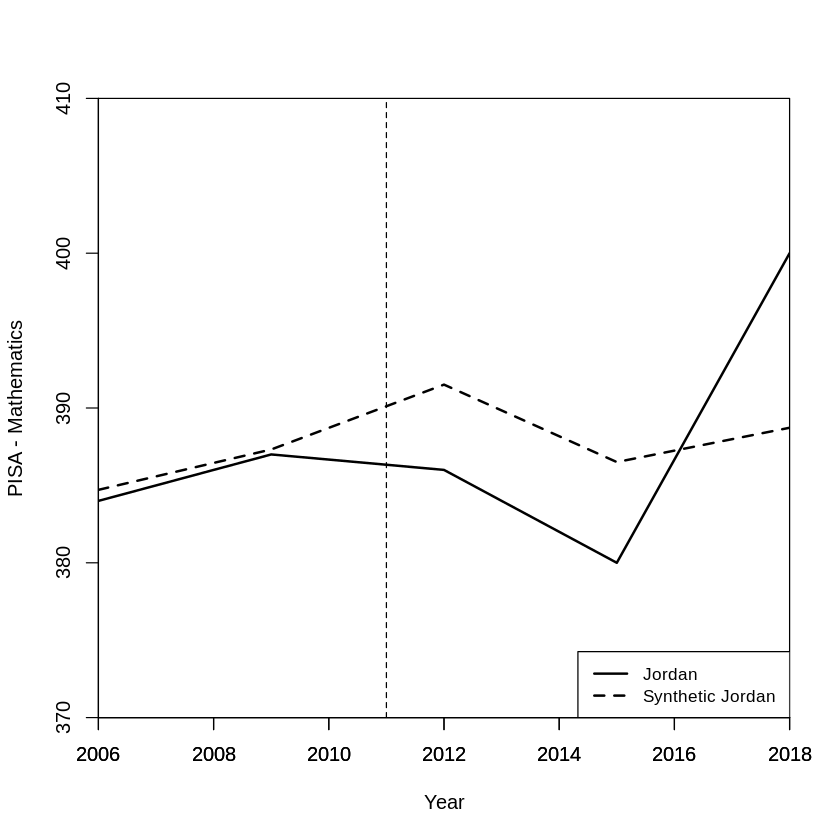

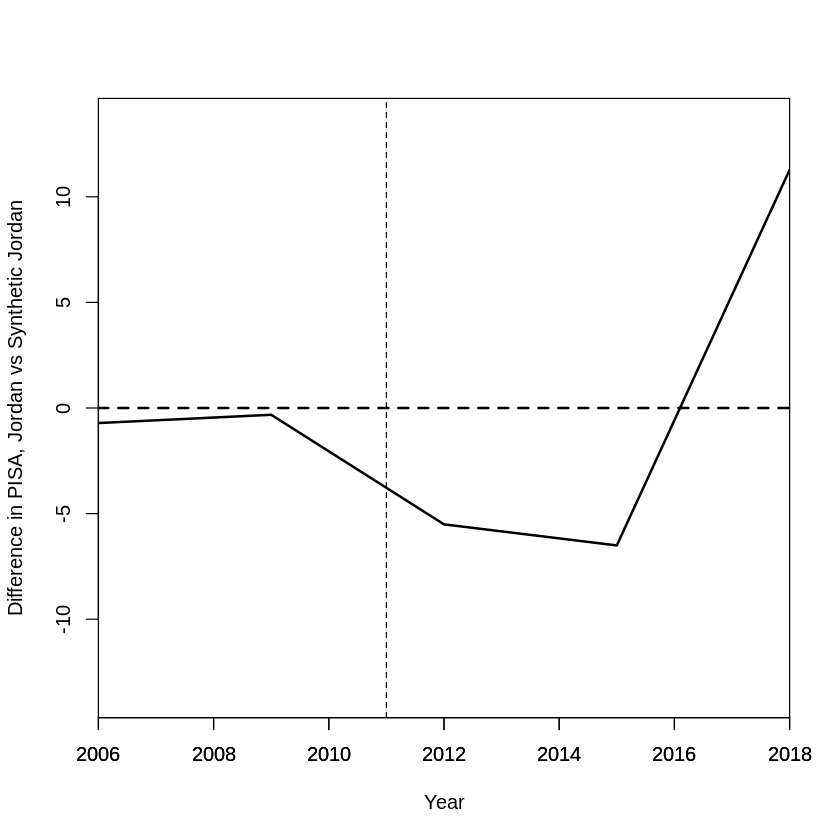

In [ ]:
# Sythnetic control
synth.math <- synth(data.prep.obj = dataprep.math)

# Creating tables
synth.tables.math <- synth.tab(dataprep.res = dataprep.math,
                          synth.res = synth.math
)
synth.tables.math$tab.w[1:13, ]
synth.tables.math$tab.pred[1:5, ]

# Path plot
path.plot(synth.res = synth.math,
          dataprep.res = dataprep.math,
          Ylab = "PISA - Mathematics",
          Xlab = "Year",
          Ylim = c(370, 410),
          Legend = c("Jordan","Synthetic Jordan"),
          Legend.position = "bottomright")
abline(v=2011, lty=2) # adding vertical line for treatment year
axis(1, at=seq(2006, 2018, by=2))

# Gaps plot
gaps.plot(synth.res = synth.math,
          dataprep.res = dataprep.math,
          Ylab = "Difference in PISA, Jordan vs Synthetic Jordan",
          Xlab = "Year",
          Main = NA)
abline(v=2011, lty=2) # adding vertical line for treatment year
axis(1, at=seq(2006, 2018, by=2))

## Placebo test 1. Donor pool countries versus Jordan

In [ ]:
# Matrix for storing results
store <- matrix(NA,5,14)
colnames(store) <- unique(data$Country)

# Extract unique Country Codes, making sure they're in the order we expect
country_codes = unique(data$`Country Code`)

# Filter out Tunisia's Country Code from the country_codes vector
country_codes = country_codes[country_codes != 14]

# Run placebo test
for (i in seq_along(country_codes))
{
    iter <- country_codes[i]

 dataprep.out <-
              dataprep(foo = data,
                       predictors = c("Population", "GDP per capita (current USD)",
                       "Political Stability and Absence of Violence/Terrorism: Percentile Rank",
                       "Student:Teacher Ratio"),
                         predictors.op = "mean",
                         time.predictors.prior=c(2006, 2009),
                         special.predictors = list(
                             list("PISA - Mathematics", 2006, 'mean'),
                             list("PISA - Reading", 2006, 'mean')),
                        dependent = "PISA_math_filled",
                        unit.variable = "Country Code",
                        unit.names.variable = "Country",
                        time.variable = "Year",
                       treatment.identifier = iter,
                       controls.identifier = country_codes[country_codes != iter],
                       time.optimize.ssr=c(2006, 2009, 2012, 2015, 2018),
                        time.plot=c(2006, 2009, 2012, 2015, 2018)
                       )


# run synth
synth.out <- synth(
                   data.prep.obj = dataprep.out,
                   method = "BFGS"
                   )

# store gaps
store[, i] <- dataprep.out$Y1plot - (dataprep.out$Y0plot %*% synth.out$solution.w)
}


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 86.82925 

solution.v:
 2.69507e-05 0.03193468 0.003017894 0.01099221 0.8366474 0.1173809 

solution.w:
 4.6e-09 0.1793774 7.89e-07 3.69e-08 0.6405935 2.7017e-06 2.238e-07 0.0001250517 0.1798901 4.8925e-06 1.0572e-06 1.2361e-06 3.0081e-06 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 68.59398 

solution.v:
 0.002013418 0.1182807 7.84519e-05 0.005534413 0.7503687 0.1237243 

solution.w:
 1.03e-08 3.0959e-06 3.1168e-06 1.745e-07 0.2536235 0.6231057 9.557e-07 4.2991e-06 0.1232205 5.9986e-06 2.7477e-06 2.44929e-05 5.3462e-06 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 


       Argentina     Brazil   Bulgaria    Croatia Hong Kong-China  Indonesia
2006  -0.8157537  -7.644863 -3.2609852  1.7597412       22.000021  20.529225
2009   7.3103952   5.397121  1.9794997 -8.4898206       30.000020 -15.364184
2012   1.3348057   7.019611  4.3010377  2.1840935       23.000022 -14.413038
2015  10.2513812  -7.235150  0.8078769  0.8696839        4.000023   8.480371
2018 -16.5277460 -12.400594 -3.0995533 -1.3536816       -6.999974  -5.461892
         Jordan Macao-China Montenegro     Qatar    Romania Russian Federation
2006 -0.3654565   -1.428915   1.312512 -52.51486  0.5761581           3.989903
2009 -0.3390869  -13.201654  -7.767613 -18.09365 -0.1800699          -3.786714
2012 -5.4509944   -6.381298   1.284947 -12.95326  7.8504237           1.580544
2015 -6.5884027    9.115396   1.716245  23.50237  2.1221335           3.142076
2018 11.1890698   19.306932   3.198827  30.23392 -6.0103711          -2.868844
      Thailand   Uruguay
2006  3.871197  13.46029
2009 -2.458219

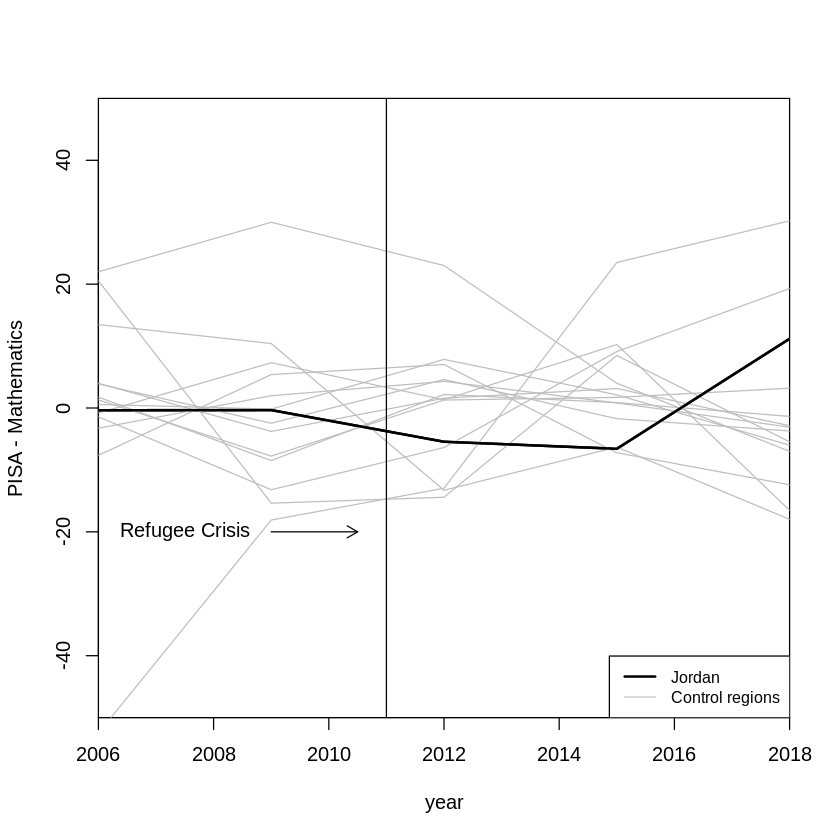

In [ ]:
# Create data for plotting
fig_d <- store
rownames(fig_d) <- c(2006,2009,2012,2015,2018)

# Set bounds in gaps data
gap.start     <- 1
gap.end       <- nrow(fig_d)
years         <- c(2006,2009,2012,2015,2018)
gap.end.pre  <- which(rownames(fig_d)=="2009")

#  MSPE Pre-Treatment
mse        <-             apply(fig_d[ gap.start:gap.end.pre,]^2,2,mean)
data.mse <- as.numeric(mse[7])

y_vec <- as.vector(fig_d[gap.start:gap.end,which(colnames(fig_d)=="Jordan")])

# Plot
plot(years,as.vector(fig_d[gap.start:gap.end,which(colnames(fig_d)=="Jordan")]),
     xlab="year",
     xlim = range(years),
     ylim = range(-50, 50),
     ylab="PISA - Mathematics",
     type="l",lwd=2,col="black",
     xaxs="i",yaxs="i")

# Add lines for control states
for (i in 1:ncol(fig_d)) { lines(years,fig_d[gap.start:gap.end,i],col="gray") } # !

## Add Jordan Line
lines(years,fig_d[gap.start:gap.end,which(colnames(fig_d)=="Jordan")],lwd=2,col="black")

# Add details
legend("bottomright",legend=c("Jordan","Control regions"),
lty=c(1,1),col=c("black","gray"),lwd=c(2,1),cex=.8)
arrows(2009,-20,2010.5,-20,col="black",length=.1)
text(2007.5,-20,"Refugee Crisis")
abline(v=2011)

print(fig_d)

## Placebo test 2. Using Brazil



In [ ]:
#Extracting control identifiers
unique_country_codes <- unique(data$`Country Code`)
exclude_codes <- c(2, 7, 14) # excluding Brazil, Jordan and Tunisia

# Filter out the excluded country codes
control_country_codes <- unique_country_codes[!unique_country_codes %in% exclude_codes]

# Dataprep
dataprep.out.2 <-
              dataprep(foo = data,
                       predictors = c("Population", "GDP per capita (current USD)", "Political Stability and Absence of Violence/Terrorism: Percentile Rank", "Student:Teacher Ratio") ,
                       predictors.op = "mean" ,
                       time.predictors.prior = c(2006, 2009),
                       special.predictors = list(
                             list("PISA - Mathematics", 2006, 'mean'),
                             list("PISA - Reading", 2006, 'mean')),
                       dependent = "PISA_math_filled",
                       unit.variable = "Country Code",
                       unit.names.variable = "Country",
                       time.variable = "Year",
                       treatment.identifier = 2, # Change the ID to other unit that did NOT receive the treatment
                       controls.identifier = control_country_codes,
                       time.optimize.ssr =c(2006, 2009, 2012, 2015, 2018),
                       time.plot = c(2006, 2009, 2012, 2015, 2018)
                       )

In [ ]:
# Synth
synth.out.2 <- synth(data.prep.obj = dataprep.out.2,
                   method = "BFGS"
                   )


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 106.0749 

solution.v:
 0.06654995 0.008695029 0.06597745 0.03382729 0.7943037 0.03064659 

solution.w:
 2.79e-08 5.11e-08 5.59e-08 7e-09 0.6662589 4.75e-08 4.094e-07 0.2267172 2.216e-07 2.04e-08 0.1070226 4.103e-07 



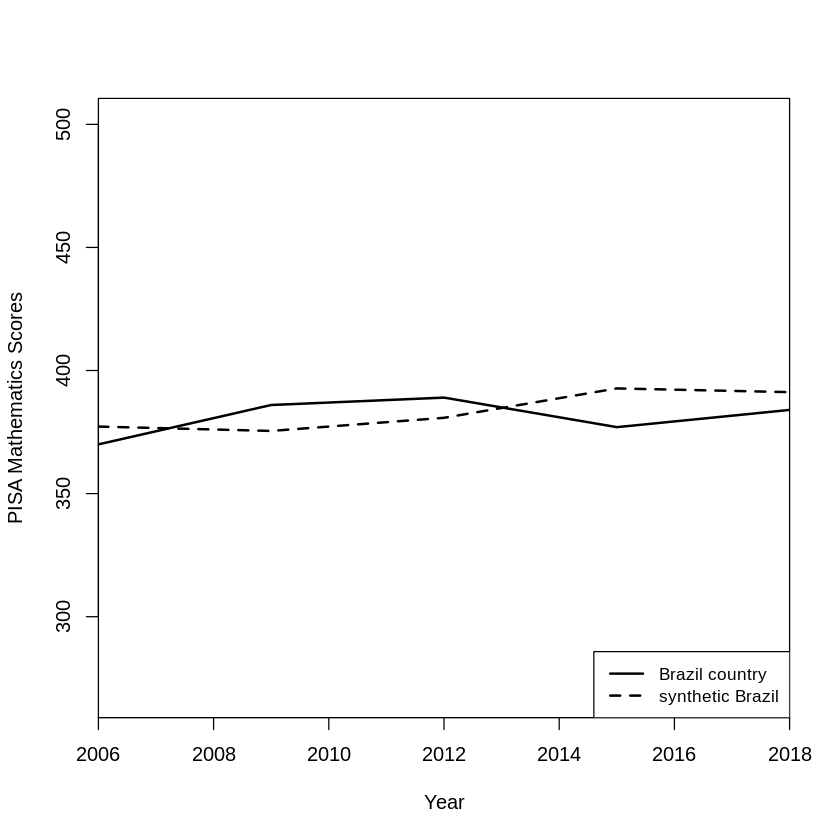

In [ ]:
# Path Plot
path.plot(synth.res = synth.out.2,
          dataprep.res = dataprep.out.2,
          tr.intake = NA,
          Ylab = "PISA Mathematics Scores",
          Xlab = "Year",
          Legend = c("Brazil country","synthetic Brazil"),
          Legend.position = "bottomright",
          )

## Robustness - Removing Donor Countries


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 80.87533 

solution.v:
 0.0005075266 0.112076 0.3411644 0.1969474 0.3403812 0.00892344 

solution.w:
 0.01814809 0.0006222335 7.88551e-05 1.0623e-06 0.7437665 5.8449e-06 0.1997884 0.03504333 0.0001197592 8.09716e-05 0.002264039 8.09615e-05 



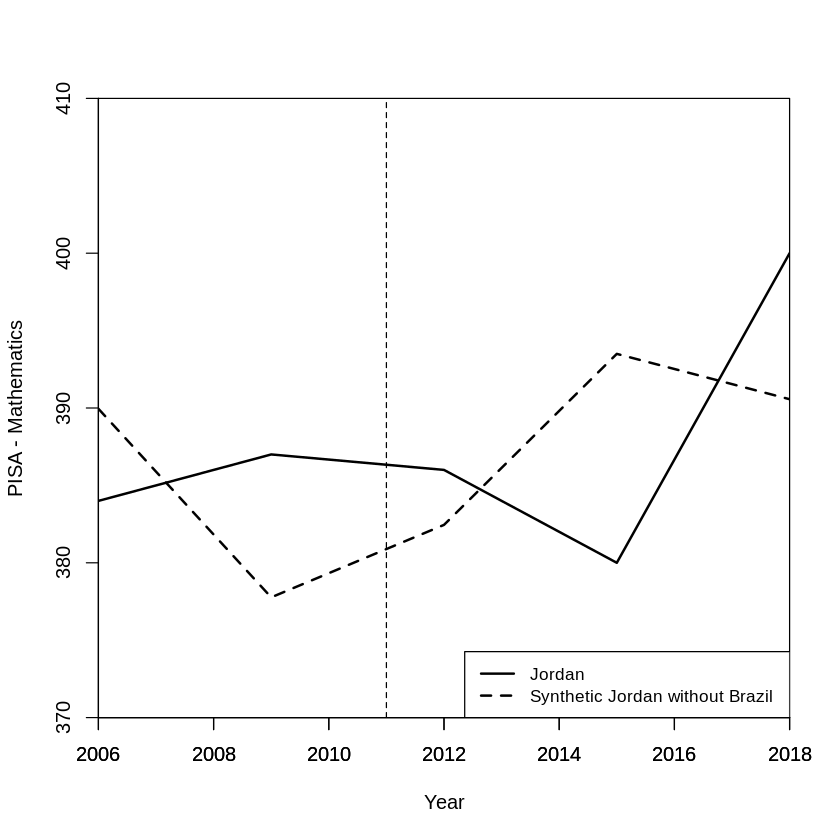

In [ ]:
# Dataprep
dataprep.out.r <-
              dataprep(foo = data,
                         predictors = c("Population", "GDP per capita (current USD)", "Political Stability and Absence of Violence/Terrorism: Percentile Rank", "Student_teach_filled"),
                         predictors.op = "mean",
                         time.predictors.prior=c(2006, 2009),
                         special.predictors = list(
                             list("PISA - Mathematics", 2006, 'mean'),
                             list("PISA - Reading", 2006, 'mean')),
                        dependent = "PISA_math_filled",
                        unit.variable = "Country Code",
                        unit.names.variable = "Country",
                        time.variable = "Year",
                       treatment.identifier = 7,
                       controls.identifier = c(1, 3:6, 8:13, 15),
                       time.optimize.ssr=c(2006, 2009, 2012, 2015, 2018),
                        time.plot=c(2006, 2009, 2012, 2015, 2018)
                       )


# Synth
synth.out.r <- synth(
                   data.prep.obj = dataprep.out.r,
                   method = "BFGS"
                   )

# Path plot
path.plot(synth.res = synth.out.r,
          dataprep.res = dataprep.out.r,
          Ylab = "PISA - Mathematics",
          Xlab = "Year",
          Ylim = c(370, 410),
          Legend = c("Jordan","Synthetic Jordan without Brazil"),
          Legend.position = "bottomright")
abline(v=2011, lty=2) # adding vertical line for treatment year
axis(1, at=seq(2006, 2018, by=2))

# Synthetic Control Analysis - Reading

## Dataprep

In [ ]:
dataprep.read <- dataprep(foo=data,
                         predictors = c("Population", "GDP per capita (current USD)", "Political Stability and Absence of Violence/Terrorism: Percentile Rank", "Student_teach_filled"),
                         predictors.op = "mean",
                         time.predictors.prior=c(2006, 2009, 2012),
                         special.predictors = list(
                             list("PISA - Mathematics", 2006, 'mean'),
                             list("PISA - Reading", 2006, 'mean')),
                        dependent = "PISA_read_filled",
                        unit.variable = "Country Code",
                        unit.names.variable = "Country",
                        time.variable = "Year",
                        treatment.identifier = 7,
                        controls.identifier = c(1:6, 8:13, 15),
                        time.optimize.ssr=c(2006, 2009, 2012, 2015, 2018),
                        time.plot=c(2006, 2009, 2012, 2015, 2018)
)

## Synthetic Control Analysis


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 71.9433 

solution.v:
 0.0007721761 0.06515934 2.41e-08 0.00108129 0.6867328 0.2462543 

solution.w:
 0.0004180543 0.5262153 1.77923e-05 0.05315967 0.0001347928 0.2219233 0.0001628323 0.1929576 1.256e-07 0.001034928 0.000574731 0.002186736 0.001214111 



,w.weights,unit.names,unit.numbers
,<dbl>,<chr>,<dbl>
1,0.000,Argentina,1
2,0.526,Brazil,2
3,0.000,Bulgaria,3
4,0.053,Croatia,4
5,0.000,Hong Kong-China,5
6,0.222,Indonesia,6
8,0.000,Macao-China,8
9,0.193,Montenegro,9
10,0.000,Qatar,10


,Treated,Synthetic,Sample Mean
Population,6689301.333,1.564216e+08,56318548.615
GDP per capita (current USD),3494.549,7.138774e+03,17809.155
Political Stability and Absence of Violence/Terrorism: Percentile Rank,28.428,4.329200e+01,53.406
Student_teach_filled,17.333,2.349500e+01,16.718
special.PISA - Mathematics.2006,384.000,3.857470e+02,426.615


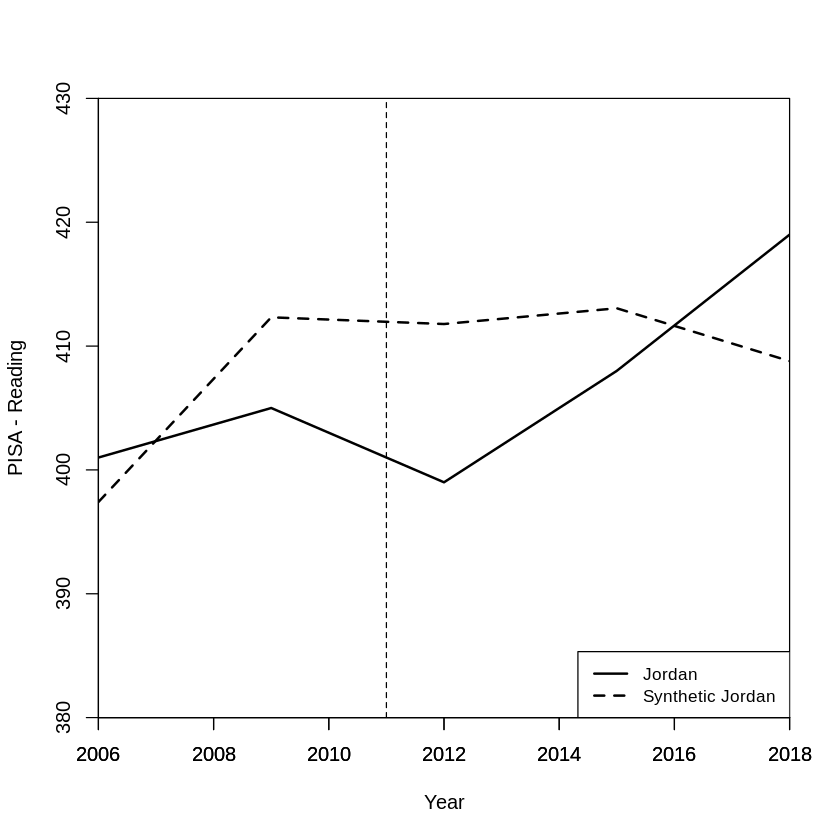

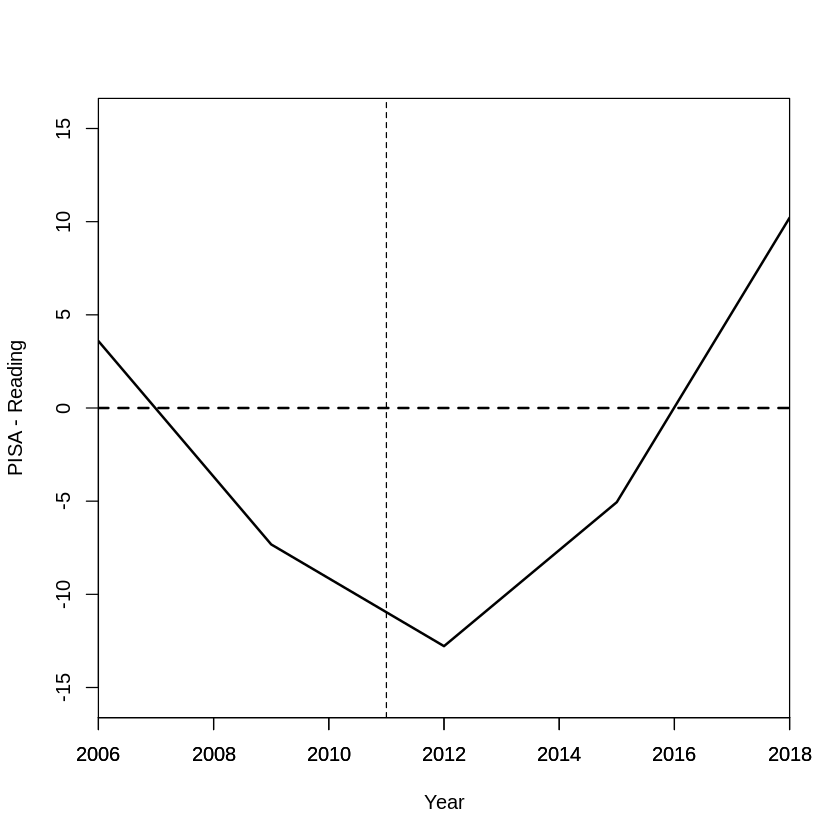

In [ ]:
# Sythnetic control
synth.read <- synth(data.prep.obj = dataprep.read)

# Creating tables
synth.tables.read <- synth.tab(dataprep.res = dataprep.read,
                          synth.res = synth.read
)
synth.tables.read$tab.w[1:13, ]
synth.tables.read$tab.pred[1:5, ]

# Path plot
path.plot(synth.res = synth.read,
          dataprep.res = dataprep.read,
          Ylab = "PISA - Reading",
          Xlab = "Year",
          Ylim = c(380,430),
          Legend = c("Jordan","Synthetic Jordan"),
          Legend.position = "bottomright")
abline(v=2011, lty=2) # adding vertical line for treatment year
axis(1, at=seq(2006, 2018, by=2))

# Gaps plot
gaps.plot(synth.res = synth.read,
          dataprep.res = dataprep.read,
          Ylab = "PISA - Reading",
          Xlab = "Year",
          Main = NA)
abline(v=2011, lty=2) # adding vertical line for treatment year
axis(1, at=seq(2006, 2018, by=2))